In [1]:
import datajoint as dj

In [2]:
dj.config['database.host'] = 'tutorial-db.datajoint.io'
schema = dj.schema('catalog_gordon', locals())

Connecting dimitri@tutorial-db.datajoint.io:3306


In [3]:
@schema
class Patient(dj.Manual):
    definition = """
    patient_id  : int   # institution patient ID
    ----
    first_name  : varchar(60)
    last_name   : varchar(60)
    date_of_birth : date
    """

In [4]:
@schema
class ImagingSession(dj.Manual):
    definition = """
    -> Patient
    session  : smallint   # session number
    ---
    session_date : date 
    session_notes : varchar(4000)   # free-hand notes
    """

In [5]:
@schema
class ImageVolume(dj.Imported):
    definition = """
    # Raw image data from DICOM
    -> ImagingSession
    volume  : smallint  # volume number within session
    ---
    volume_array : longblob    # 3D array
    """
    
    def _make_tuples(self, key):
        raise NotImplemented
        for img in read_dicom(key):
            self.insert1(dict(key, volume_array=img))

In [6]:
@schema
class Baseline(dj.Manual):
    definition = """
    # A baseline image for the patient
    -> Patient
    baseline  : smallint   # baseline number for the patient
    ---
    baseline_image  : longblob
    """

In [7]:
@schema
class RegisteredVolume(dj.Computed):
    definition = """
    # Registration of volumes to baseline volume
    -> ImageVolume
    -> Baseline
    ---
    transform  :  longblob  # transformation from volume to baseline
    registered_image  : longblob  # volume registered to baseline
    """
    
    def _make_tuples(self, key):
        volume = (ImageVolume() & key).fetch1('volume_array')
        baseline = (BaseLine() & key).fetch1('baseline_image')
        registered_image, transform = mylib.register(volume, baseline)
        self.insert1(dict(key, transform=transform, registered_image=registered_image))
        

In [8]:
@schema
class SkullRemoved(dj.Computed):
    definition = """
    # Registered volume with skull removed
    -> RegisteredVolume
    ---
    skullless  : longblob  # volume with skulll removed
    """
    
    def _make_tuples(self, key):
        image = (RegisteredVolume() & key).fetch1(registered_image)
        skullless = mylib.remove_skull(image)
        self.insert1(dict(key, skullless=skullless))

In [9]:
@schema
class AnatomicalStructure(dj.Lookup):
    definition = """
    # Anatomical structures for modeling
    anatomical_structure  : varchar(8)  # short name
    ---
    structure_description  : varchar(255)  # full name
    """
    contents = (
        ['FuG', 'fusiform gyrus'],
        ['LV', 'lateral ventricle'],
        ['PoG', 'postcentral gyrus']
    )

In [10]:
AnatomicalStructure()

anatomical_structure short name,structure_description full name
FuG,fusiform gyrus
LV,lateral ventricle
PoG,postcentral gyrus


In [11]:
@schema
class Geometry(dj.Computed):
    definition = """
    # Geometric model of anatomcal structures
    -> SkullRemoved
    """
    
    class Mesh(dj.Part):
        definition = """
        -> Geometry
        -> AnatomicalStructure
        ---
        n_vertices : int 
        n_triangles : int
        vertices  : longblob   # (x,y,z) (mm) coordinates
        triangles : longblob   # (v1,v2,v3) - vertex indices
        """    

In [12]:
@schema
class Atlas(dj.Lookup):
    definition = """
    # Anatomical atlas for common coordinate spaces
    atlas : varchar(12)  # anatomical atlas
    ---
    """

In [13]:
@schema
class AtlasImage(dj.Computed):
    definition = """
    # Geometry in atlas coordinates
    -> Geometry
    -> Atlas
    ---
    atlas_transformation : longblob  #  transformation from patient coordinates to atlas coordinates
    atlas_image          : longblob  #  skulless image in atlas coordinates
    """

In [14]:
AtlasImage()

patient_id institution patient ID,session session number,volume volume number within session,baseline baseline number for the patient,atlas anatomical atlas,atlas_transformation calculated attribute,atlas_image calculated attribute


In [15]:
@schema
class RefAtlasImage(dj.Manual):
    definition = """
    # A reference geometry (another patient/geometry) 
    (ref_patient, ref_session, ref_volume, ref_baseline) -> AtlasImage(patient_id, session, volume, baseline)
    """

@schema
class ComparativeAnalysis(dj.Computed):
    definition = """
    -> AtlasImage
    -> RefAtlasImage
    ---
    comparative_analysis : longblob 
    """    

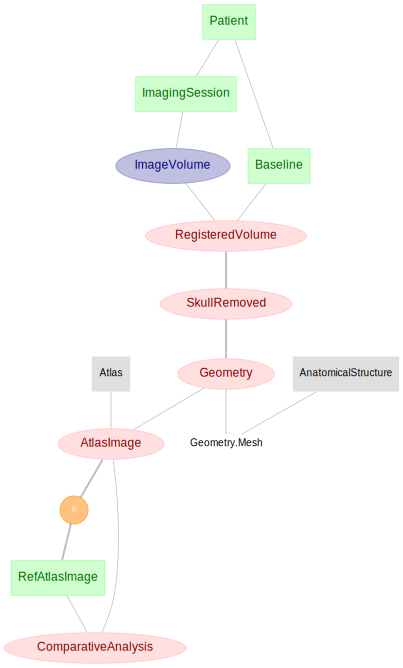

In [16]:
dj.ERD(schema)

In [17]:
# schema.drop()